In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [2]:
np.random.seed(102)

In [3]:
# Generate 2D set of 20 points inside the unit square of the 1st quadrant
rand_x = np.random.uniform(size=(20,2))
rand_x

array([[0.59768158, 0.6759869 ],
       [0.29928174, 0.73074027],
       [0.57873939, 0.80901767],
       [0.1672485 , 0.31214497],
       [0.35793155, 0.4917473 ],
       [0.49019824, 0.89440989],
       [0.18241053, 0.36116209],
       [0.81059146, 0.33344683],
       [0.5189505 , 0.26162022],
       [0.13092809, 0.12241719],
       [0.55165734, 0.02938371],
       [0.60277512, 0.75088233],
       [0.24907072, 0.19767774],
       [0.57395606, 0.90179842],
       [0.51621644, 0.40119864],
       [0.51748975, 0.93739107],
       [0.85040822, 0.17550296],
       [0.51981914, 0.50576435],
       [0.34856036, 0.07084276],
       [0.57598201, 0.4017127 ]])

In [4]:
# All points with x1 > x2 belong to positive class, else belong to negative class
# True separator of the two classes is a linear hyperplane where x1 - x2 = 0
df = pd.DataFrame({"x1": rand_x[:,0], "x2": rand_x[:,1]})
cls = df["x1"] - df["x2"]
df["class"] = cls.apply(lambda x: 1 if x > 0 else -1)
df.head()

# Define inputs and labels
X_train = df.iloc[:,0:2].values
y_train = df.iloc[:,2].values

In [5]:
"""
PERCEPTRON

activation = sum(weight_i * x_i) + bias
prediction = 1.0 if activation >= 0.0 else 0.0

optimize weights: w <- w + learning_rate(y_expected - y_predicted) * x 
E(X) = error = y_expected - y_predicted

Perceptron Loss: max(0, y_exp * y_pred)
Hinge Loss: max(0, 1 - y_exp * y_pred)

Mean-Squared Error: sum((y_pred - y_exp)^2) / y_exp.size
"""

class Perceptron(object):
    
    def __init__(self, num_inputs, epochs=100, loss_func="perceptron", learning_rate=0.01):
        self.epochs = epochs
        self.loss_func = loss_func
        self.learning_rate = learning_rate
        self.weights = np.zeros(num_inputs + 1) # weights[0] = bias term, weights[1:] = weight for each input/feature
        self.errors_ = []
        
    def loss_perceptron(self, y_pred, y_exp):
        return np.maximum(0, -y_exp * y_pred) # max(0, -y*yHat)
        
    def loss_hinge(self, y_pred, y_exp):
        return np.maximum(0, 1 - y_exp * y_pred) # max(0, 1-y*yHat)
    
    def loss_mse(self, y_pred, y_exp): # aka L2 loss
        return (y_exp - y_pred)**2 # (y - yHat)^2
    
    def loss(self, prediction, label):
        if (self.loss_func == "mse"):
            return self.loss_mse(prediction, label)
        elif (self.loss_func == "hinge"):
            return self.loss_hinge(prediction, label)
        else: 
            # default to perceptron loss
            return self.loss_perceptron(prediction, label)
        
    def update(self, label, pred):
        if (self.loss_func == "mse"): # sum of squared errors uses linear activation
            
            return self.learning_rate * (label - pred) # LSE updates
        
        elif (self.loss_func == "hinge"): # make updates like an SVM
            
            if (label*pred < 1): # y(W*X) < 1
                return self.learning_rate * label # alpha * misclassified y's
            else:
                return 0
            
        else:
            # updates for perceptron made by sign function
            pred_sign = np.where(pred >= 0, 1, -1)
            return self.learning_rate * (label - pred_sign) # alpha * (y - yHat)
 
    def predict(self, inputs): # f(x) = 1 if w * x + b > 0 : 0 otherwise
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0] # activation computation
        
        activation = np.where(summation >= 0, 1, -1) # sign activation function - for testing not training
        
        return activation
    
    def train(self, training_inputs, labels):
        
        self.errors_ = []
        
        for epoch in range(self.epochs): # go through each epoch
            errors = 0
            for inputs, label in zip(training_inputs, labels): # inputs
                
                prediction = self.predict(inputs)
                summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
                
                self.weights[1:] += self.update(label, summation) * inputs # weight optimizer
                self.weights[0] += self.update(label, summation) # bias update
                errors += (self.loss(summation, label))
            if (self.loss_func == "mse"): # mse/sse = 1/N * sum(y_i - yHat_i)^2, N=2
                errors *= 0.5
            self.errors_.append(errors)
            
        # Plot decision regions and loss at the end
        self.plot_epochs(training_inputs, labels)
            
    def plot_epochs(self, inputs, labels):
        plot_decision_regions(inputs, labels, clf=self, colors='red,blue')
        plt.title('Perceptron')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.show()

        plt.plot(range(1, len(self.errors_)+1), self.errors_, marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.show()

In [6]:
ppn = Perceptron(2, epochs=800)
ppn_hinge = Perceptron(2, epochs=800, loss_func="hinge")
ppn_mse = Perceptron(2, epochs=800, loss_func="mse")

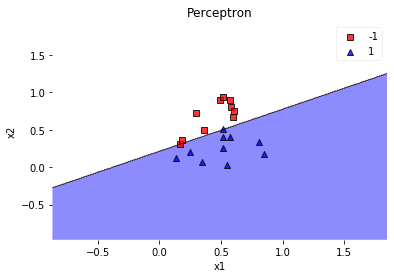

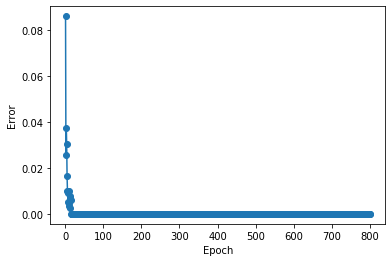

In [7]:
ppn.train(X_train,y_train)

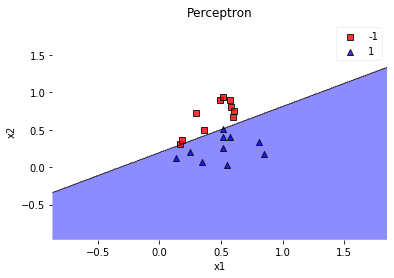

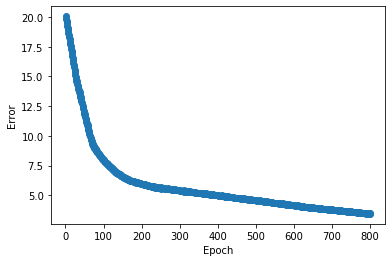

In [8]:
ppn_hinge.train(X_train,y_train)

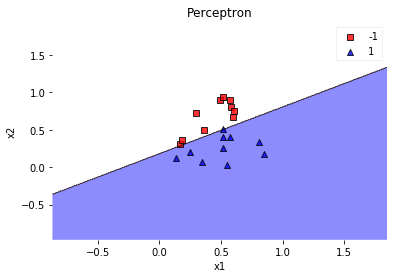

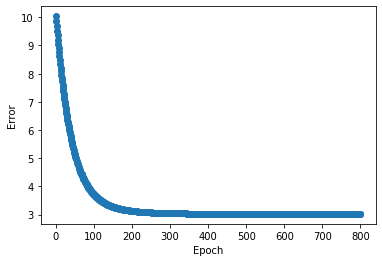

In [9]:
ppn_mse.train(X_train,y_train)

In [10]:
print(ppn.weights)
print(ppn_hinge.weights)
print(ppn_mse.weights)

[ 0.02        0.05249674 -0.09337806]
[ 1.33        4.17401421 -6.77151079]
[ 0.52973015  1.82048997 -2.9142931 ]


In [11]:
# Create 1000 random uniform test points
rand_x_test = np.random.uniform(size=(1000,2))
df_test = pd.DataFrame({"x1": rand_x_test[:,0], "x2": rand_x_test[:,1]})
cls_test = df_test["x1"] - df_test["x2"]
df_test["class"] = cls_test.apply(lambda x: 1 if x > 0 else -1)
df_test.head()

,x1,x2,class
0,0.911415,0.808886,1
1,0.132057,0.714864,-1
2,0.346663,0.614411,-1
3,0.287490,0.985570,-1
4,0.272213,0.819392,-1


In [12]:
X_test = df_test.iloc[:,0:2].values
y_test = df_test.iloc[:,2].values
data = df_test.iloc[:,0:3].values

In [15]:
y_pred = []
loss_ppn = 0
for value in data:
    point = value[0:2]
    label = value[2]
    prediction = ppn.predict(point)
    y_pred.append(prediction)
    loss_ppn += (ppn.loss(prediction, label))

# Perceptron Loss
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.90      0.92      0.91       487
           1       0.93      0.90      0.91       513

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

[[450  37]
 [ 52 461]]


In [16]:
y_pred = []
loss_hinge = 0
for value in data:
    point = value[0:2]
    label = value[2]
    prediction = ppn_hinge.predict(point)
    y_pred.append(prediction)
    loss_hinge += (ppn_hinge.loss(prediction, label))
    
# Hinge Loss
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.92      0.93      0.92       487
           1       0.93      0.92      0.93       513

    accuracy                           0.93      1000
   macro avg       0.92      0.93      0.92      1000
weighted avg       0.93      0.93      0.93      1000

[[452  35]
 [ 40 473]]


In [17]:
y_pred = []
loss_mse = 0
for value in data:
    point = value[0:2]
    label = value[2]
    prediction = ppn_mse.predict(point)
    y_pred.append(prediction)
    loss_mse += (ppn_mse.loss(prediction, label))
    
# MSE Loss
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.91      0.93      0.92       487
           1       0.93      0.91      0.92       513

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

[[454  33]
 [ 46 467]]


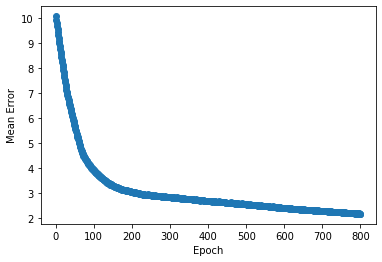

In [19]:
mean = np.add(ppn.errors_, ppn_hinge.errors_)
meaner = np.add(mean, ppn_mse.errors_)
loss_mean = meaner / 3

# Mean Training Error Plot
plt.plot(range(1, len(loss_mean)+1), loss_mean, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Mean Error')
plt.show()

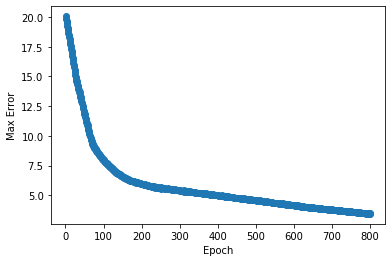

In [20]:
mx = np.maximum(ppn.errors_, ppn_hinge.errors_)
maxer = np.maximum(mx, ppn_mse.errors_)
loss_max = maxer

# Maximum Training Error Plot
plt.plot(range(1, len(loss_max)+1), loss_max, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Max Error')
plt.show()